<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 09 &mdash; Optimal Execution**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Model Implementation

In [1]:
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

In [3]:
class AlmgrenChriss:
    def __init__(self, T, N, S0, sigma, X, gamma, eta, lamb):
        self.T = T              
        self.N = N           
        self.dt = T / N
        self.S0 = S0
        self.sigma = sigma
        self.X = X
        self.gamma = gamma
        self.eta = eta
        self.lamb = lamb

In [4]:
class AlmgrenChriss(AlmgrenChriss):
    def optimal_execution(self):
        kappa = np.sqrt(self.lamb * self.sigma ** 2 / self.eta)
        t = np.linspace(0, self.T, self.N + 1)
        xt_sum = (self.X * np.sinh(kappa * (self.T - t)) /
                  np.sinh(kappa * self.T))
        xt = -np.diff(xt_sum, prepend=0)
        xt[0] = 0
        return t, xt

In [5]:
T = 10
N = 10
S0 = 1
sigma = 0.15
X = 1
gamma = 0.1
eta = 0.1
lamb_high = 0.2
lamb_low = 0.0001

In [6]:
ac = AlmgrenChriss(T, N, S0, sigma, X, gamma, eta, lamb_high)

In [7]:
t, xth = ac.optimal_execution()

In [8]:
t

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [9]:
xth.round(3)

array([0.   , 0.197, 0.161, 0.132, 0.109, 0.091, 0.077, 0.067, 0.059,
       0.054, 0.052])

In [10]:
ac.lamb = lamb_low

In [11]:
t, xtl = ac.optimal_execution()
xtl.round(3)

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

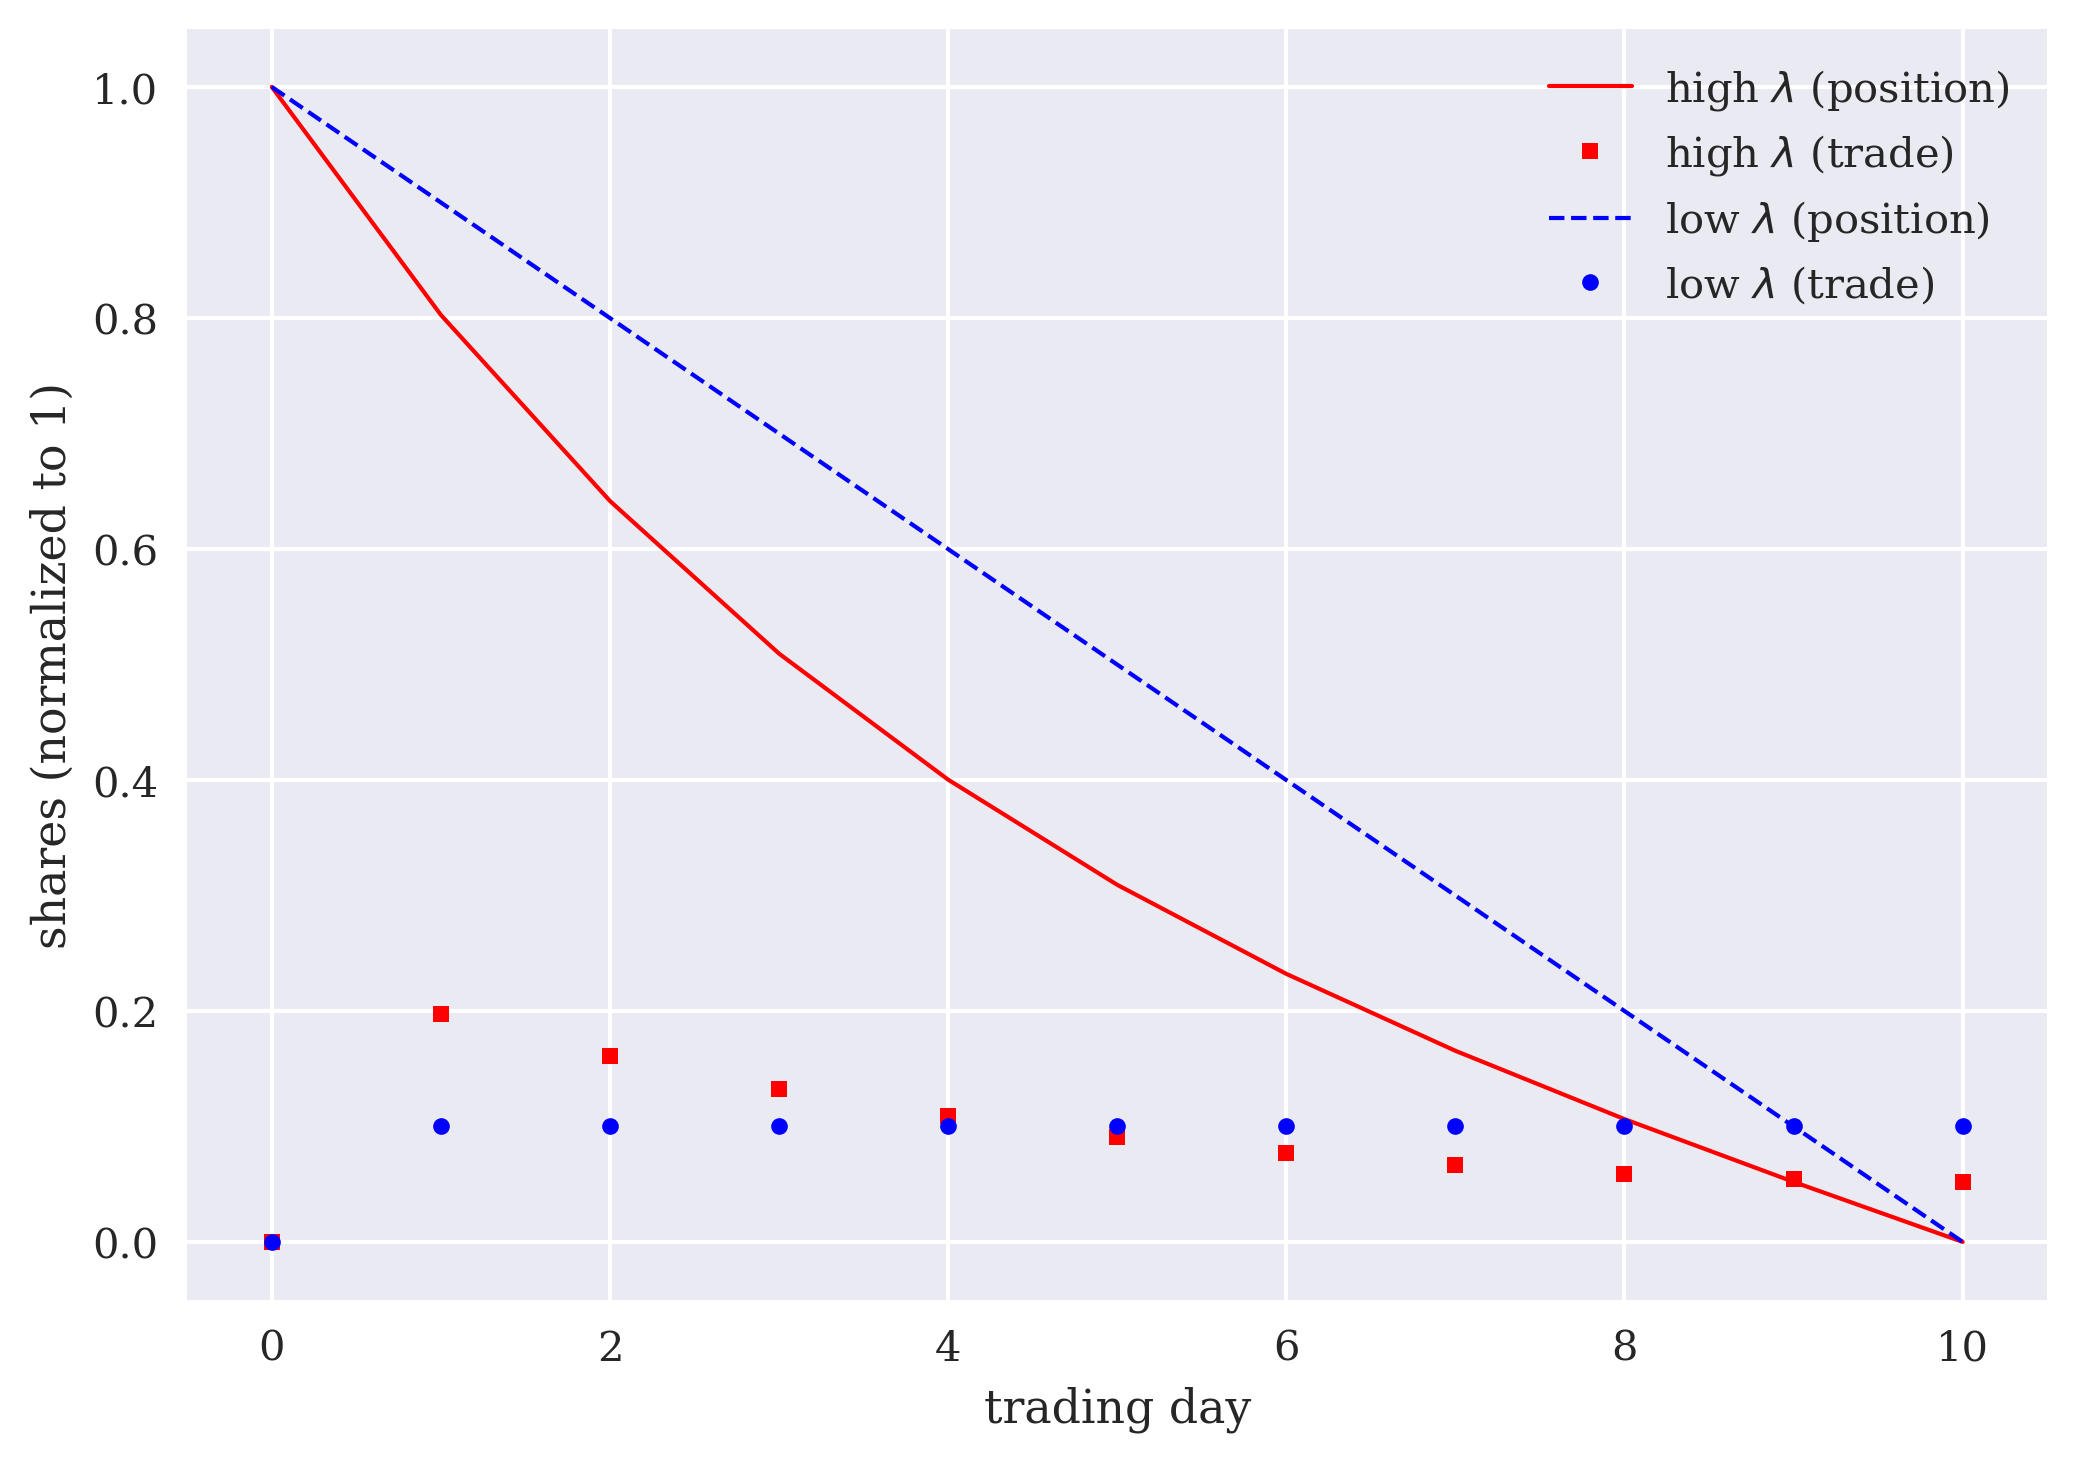

In [12]:
plt.plot(t, ac.X - xth.cumsum(), 'r', lw=1,
         label='high $\\lambda$ (position)')
plt.plot(t, xth, 'rs', markersize=4,
         label='high $\\lambda$ (trade)')
plt.plot(t, ac.X- xtl.cumsum(), 'b--', lw=1,
         label='low $\\lambda$ (position)')
plt.plot(t, xtl, 'bo', markersize=4,
         label='low $\\lambda$ (trade)')
plt.xlabel('trading day')
plt.ylabel('shares (normalized to 1)')
plt.legend();

In [13]:
from numpy.random import default_rng

In [14]:
class AlmgrenChriss(AlmgrenChriss):
    def simulate_stock_price(self, xt, seed=None):
        rng = default_rng(seed=seed)
        S = np.zeros(self.N + 1)
        S[0] = self.S0
        P = np.zeros(self.N + 1)
        P[0] = self.S0
        for t in range(1, self.N + 1):
            dZ = rng.normal(0, np.sqrt(self.dt))
            S[t] = S[t - 1] + sigma * dZ
            P[t] = S[t] - self.gamma * xt[:t + 1].sum()
        return S, P

In [15]:
ac = AlmgrenChriss(T, N, S0, sigma, X, gamma, eta, lamb_high)

In [16]:
t, xth = ac.optimal_execution()

In [17]:
xth.round(2)

array([0.  , 0.2 , 0.16, 0.13, 0.11, 0.09, 0.08, 0.07, 0.06, 0.05, 0.05])

In [18]:
seed = 250

In [19]:
S, Ph = ac.simulate_stock_price(xth, seed=seed)

In [20]:
ac.lamb = lamb_low

In [21]:
t, xtl = ac.optimal_execution()

In [22]:
xtl.round(2)

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [23]:
S, Pl = ac.simulate_stock_price(xtl, seed=seed)

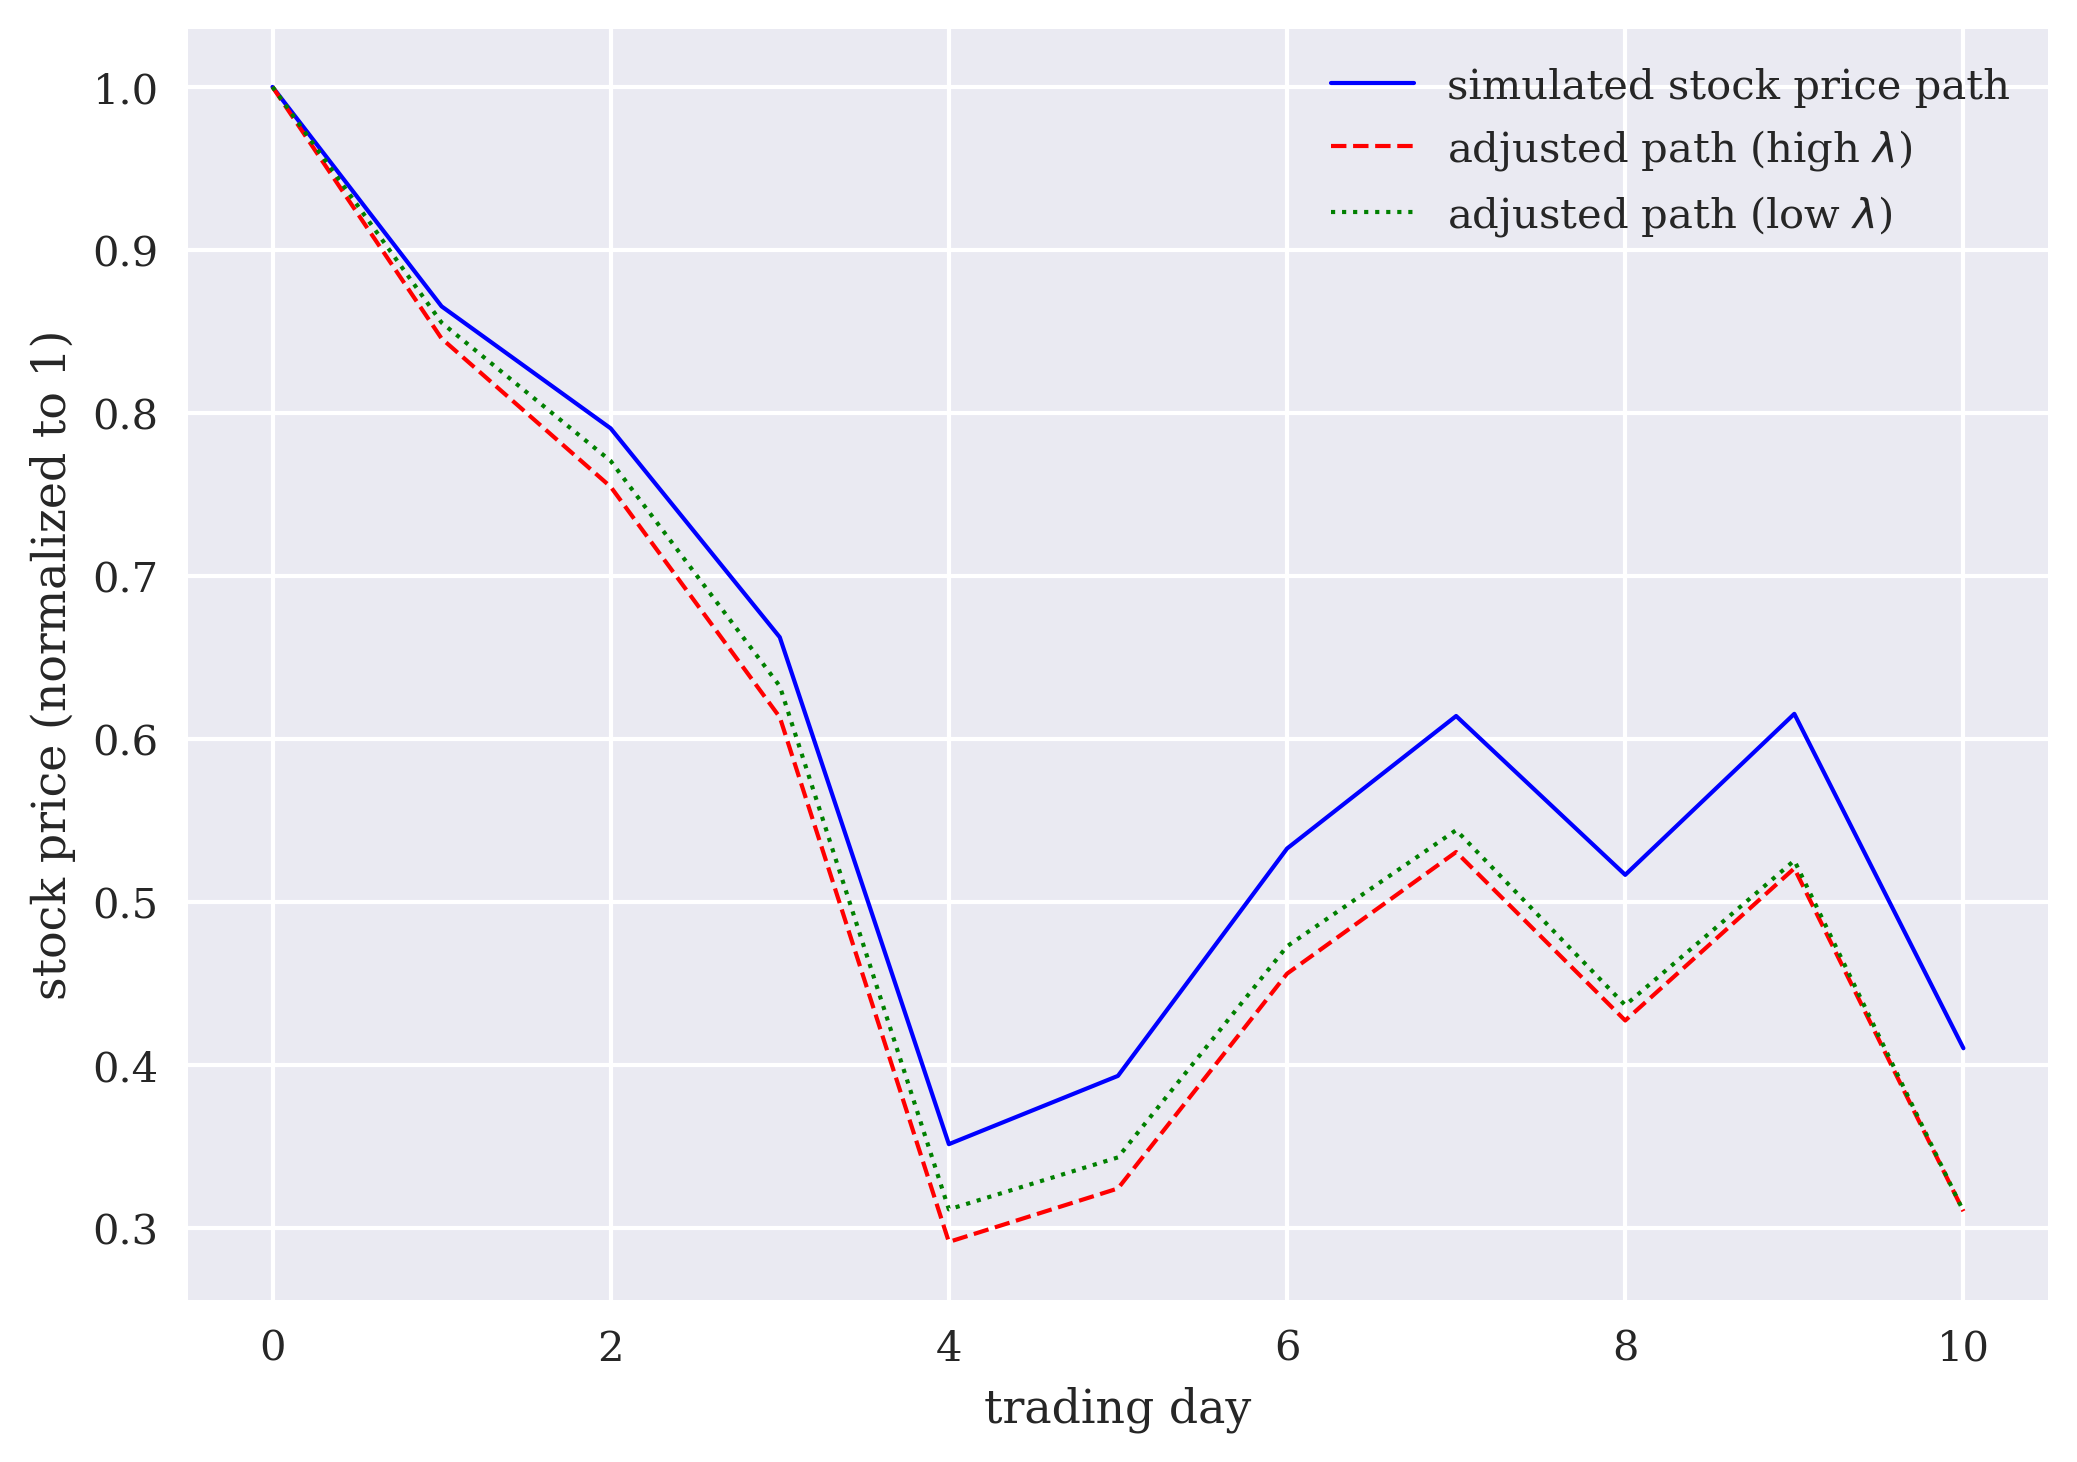

In [24]:
plt.plot(t, S, 'b', lw=1, label='simulated stock price path')
plt.plot(t, Ph, 'r--', lw=1, label='adjusted path (high $\\lambda$)')
plt.plot(t, Pl, 'g:', lw=1, label='adjusted path (low $\\lambda$)')
plt.xlabel('trading day')
plt.ylabel('stock price (normalized to 1)')
plt.legend();

In [25]:
class AlmgrenChriss(AlmgrenChriss):
    def calculate_costs(self, xt):
        temporary_cost = np.sum(self.eta *
                    (xt / self.dt) ** 2 * self.dt)
        permanent_cost = np.sum(self.gamma * np.cumsum(xt) * xt)
        execution_risk = self.lamb * self.sigma ** 2 * np.sum(
            (np.cumsum(xt[::-1])[::-1] / self.dt) ** 2 * self.dt)
        TEC = temporary_cost + permanent_cost + execution_risk
        return temporary_cost, permanent_cost, execution_risk, TEC

In [26]:
ac = AlmgrenChriss(T, N, S0, sigma, X, gamma, eta, lamb_high)

In [27]:
t, xth = ac.optimal_execution()

In [28]:
tc, pc, er, TEC = ac.calculate_costs(xth)

In [29]:
print(f'lambda = {ac.lamb}')
print(f'temporary cost = {tc:7.4f}')
print(f'permanent cost = {pc:7.4f}')
print(f'execution risk = {er:7.4f}')
print(f'total ex. cost = {TEC:7.4f}')

lambda = 0.2
temporary cost =  0.0122
permanent cost =  0.0561
execution risk =  0.0165
total ex. cost =  0.0848


In [30]:
ac.lamb = lamb_low

In [31]:
t, xtl = ac.optimal_execution()

In [32]:
tc, pc, er, TEC = ac.calculate_costs(xtl)

In [33]:
print(f'lambda = {ac.lamb}')
print(f'temporary cost = {tc:7.4f}')
print(f'permanent cost = {pc:7.4f}')
print(f'execution risk = {er:7.4f}')
print(f'total ex. cost = {TEC:7.4f}')

lambda = 0.0001
temporary cost =  0.0100
permanent cost =  0.0550
execution risk =  0.0000
total ex. cost =  0.0650


## Execution Environment

In [34]:
class Execution:
    def __init__(self, T, N, sigma, X, gamma, eta, lamb):
        self.T = T              
        self.N = N           
        self.dt = T / N
        self.sigma = sigma
        self.X = X
        self.gamma = gamma
        self.eta = eta
        self.lamb = lamb
        self.episode = 0

In [35]:
class Execution(Execution):
    def _get_state(self):
        s = np.array([self.X_,
                    self.bar / self.N])
        state = np.hstack((self.xt, s))
        return state, {}
    def reset(self):
        self.bar = 0
        self.treward = 0
        self.episode += 1
        self.X_ = self.X
        self.xt = np.zeros(self.N + 1)
        self.tec = pd.DataFrame(
            {'pc': 0, 'tc': 0, 'er': 0}, index=[0])
        return self._get_state()

In [36]:
class Execution(Execution):
    def step(self, action):
        self.bar += 1
        self.xt[self.bar] = action
        self.X_ -= action
        pc = np.sum(self.gamma *
                np.cumsum(self.xt) * self.xt)
        tc = np.sum(self.eta *
                (self.xt / self.dt) ** 2 * self.dt)
        er = self.lamb * self.sigma ** 2 * np.sum(
            (np.cumsum(self.xt[::-1])[::-1] / self.dt) ** 2
            * self.dt)
        df = pd.DataFrame({'pc': tc, 'tc': pc, 'er': er},
                          index=[0])
        self.tec = pd.concat((self.tec, df))
        cost = self.tec.diff().fillna(0).iloc[-1]
        tec = cost.sum()
        self.state, _ = self._get_state()
        pen = 0
        if self.bar < self.N:
            if self.X_ <= 0.0001:
                done = True
            else:
                done = False
        elif self.bar == self.N:
            pen = abs(self.X_) * 10
            done = True
        return self.state, -(tec + pen), done, False, {}

In [37]:
execution = Execution(T, N, sigma, X, gamma, eta, lamb_low)

In [38]:
execution.reset()
execution.step(1.0)

(array([0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1]),
 -0.2000045,
 True,
 False,
 {})

In [39]:
execution.reset()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), {})

In [40]:
execution.step(0.5)

(array([0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.1]),
 -0.050001125,
 False,
 False,
 {})

In [41]:
execution.step(0.5)

(array([0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2]),
 -0.0750039375,
 True,
 False,
 {})

In [42]:
execution.reset()
cost = list()
for i in range(10):
    cost.append(execution.step(0.1)[1])
print(f'TEC = {sum(cost):.3f}')

TEC = -0.065


In [43]:
execution = Execution(T, N, sigma, X, gamma, eta, lamb_low)

In [44]:
rng = default_rng(seed=100)

In [45]:
def gen_rn():
    alpha = np.ones(N)
    rn = rng.dirichlet(alpha)
    rn = np.insert(rn, 0, 0)
    return rn

In [46]:
rn = gen_rn()
rn

array([0.        , 0.15895546, 0.12542041, 0.07457818, 0.00209012,
       0.08708588, 0.02557811, 0.05065022, 0.23502973, 0.16044992,
       0.08016197])

In [47]:
rn.sum()

1.0000000000000002

In [48]:
def execute_trades():
    for _ in range(5):
        execution.reset()
        rn = gen_rn()
        for i in range(1, 11):
            execution.step(rn[i])
        tec = execution.tec.iloc[-1].sum()
        print(f'TEC = {tec:.3f}')

In [49]:
execute_trades()

TEC = 0.072
TEC = 0.078
TEC = 0.081
TEC = 0.071
TEC = 0.099


In [50]:
execution = Execution(T, N, sigma, X, gamma, eta, lamb_high)

In [51]:
execute_trades()

TEC = 0.105
TEC = 0.103
TEC = 0.097
TEC = 0.097
TEC = 0.093


In [52]:
from dqlagent import *

In [53]:
random.seed(100)
tf.random.set_seed(100)

In [54]:
opt = keras.optimizers.legacy.Adam

In [55]:
class ExecutionAgent(DQLAgent):
    def __init__(self, symbol, feature, n_features, env,
                 hu=24, lr=0.0001, rng='equal'):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.eta = 1.0
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self.rng = rng
        self._generate_rn()
        self.actor = self._create_model(hu, lr, 'sigmoid')
        self.critic = self._create_model(hu, lr, 'linear')

In [56]:
class ExecutionAgent(ExecutionAgent):
    def _generate_rn(self):
        if self.rng == 'equal':
            alpha = np.ones(self.env.N)
        elif self.rng == 'decreasing':
            alpha = range(self.env.N, 0, -1)
        else:
            alpha = rng.random(self.env.N)
        rn = rng.dirichlet(alpha)
        self.rn = np.insert(rn, 0, 0)

In [57]:
class ExecutionAgent(ExecutionAgent): 
    def _create_model(self, hu, lr, out_activation):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(1, activation=out_activation))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model

In [58]:
class ExecutionAgent(ExecutionAgent):    
    def act(self, state):
        if random.random() <= self.epsilon or self.episodes < 250:
            return min(self.rn[self.f], state[0, -2])
        else:
            action = self.actor.predict(state)[0, 0]
        return action

In [59]:
class ExecutionAgent(ExecutionAgent):
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                target += self.eta * self.critic.predict(
                        next_state)[0, 0]
                self.critic.fit(state, np.array([target]),
                        epochs=1, verbose=False)
                # advantage = target - self.critic.predict(state)[0, 0]
                self.actor.fit(state, np.array([action]),
                        # sample_weight=np.array([advantage]),
                        epochs=1, verbose=False) 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self._generate_rn()

In [60]:
class ExecutionAgent(ExecutionAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, self.env.N + 1):
                action = self.actor.predict(state)[0, 0]
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'total reward={treward:4.3f}'
                    if verbose:
                        print(templ)
                    break
            print(self.env.xt)

In [61]:
execution = Execution(T, N, sigma, X, gamma, eta, lamb_low)

In [62]:
executionagent = ExecutionAgent(None, feature=None,
                    n_features=execution.N + 3,
                    env=execution, hu=64, lr=0.0001,
                    rng='equal')

In [63]:
episodes = 2500

In [64]:
%time executionagent.learn(episodes)

episode=2500 | treward= -0.270 | max= -0.065
CPU times: total: 10min 45s
Wall time: 9min 44s


In [65]:
executionagent.test(1)

total reward=-0.912
[0.         0.09795622 0.09197167 0.09160777 0.09103362 0.09467746
 0.09440774 0.09722784 0.08991306 0.0855041  0.07989336]


In [66]:
xtl_ = execution.xt
xtl_.sum()

0.914192833006382

In [67]:
execution = Execution(T, N, sigma, X, gamma, eta, lamb_high)

In [68]:
executionagent = ExecutionAgent(None, feature=None,
                    n_features=execution.N + 3,
                    env=execution, hu=64, lr=0.0001,
                    rng='decreasing')

In [69]:
%time executionagent.learn(episodes)

episode=2500 | treward= -0.280 | max= -0.085
CPU times: total: 9min 40s
Wall time: 6min 15s


In [70]:
executionagent.test(1)

total reward=-0.199
[0.         0.18177018 0.16303268 0.14493093 0.11896232 0.10893399
 0.08658473 0.07199004 0.05079929 0.03398583 0.02749113]


In [71]:
xth_ = execution.xt
xth_.sum()

0.9884811267256737

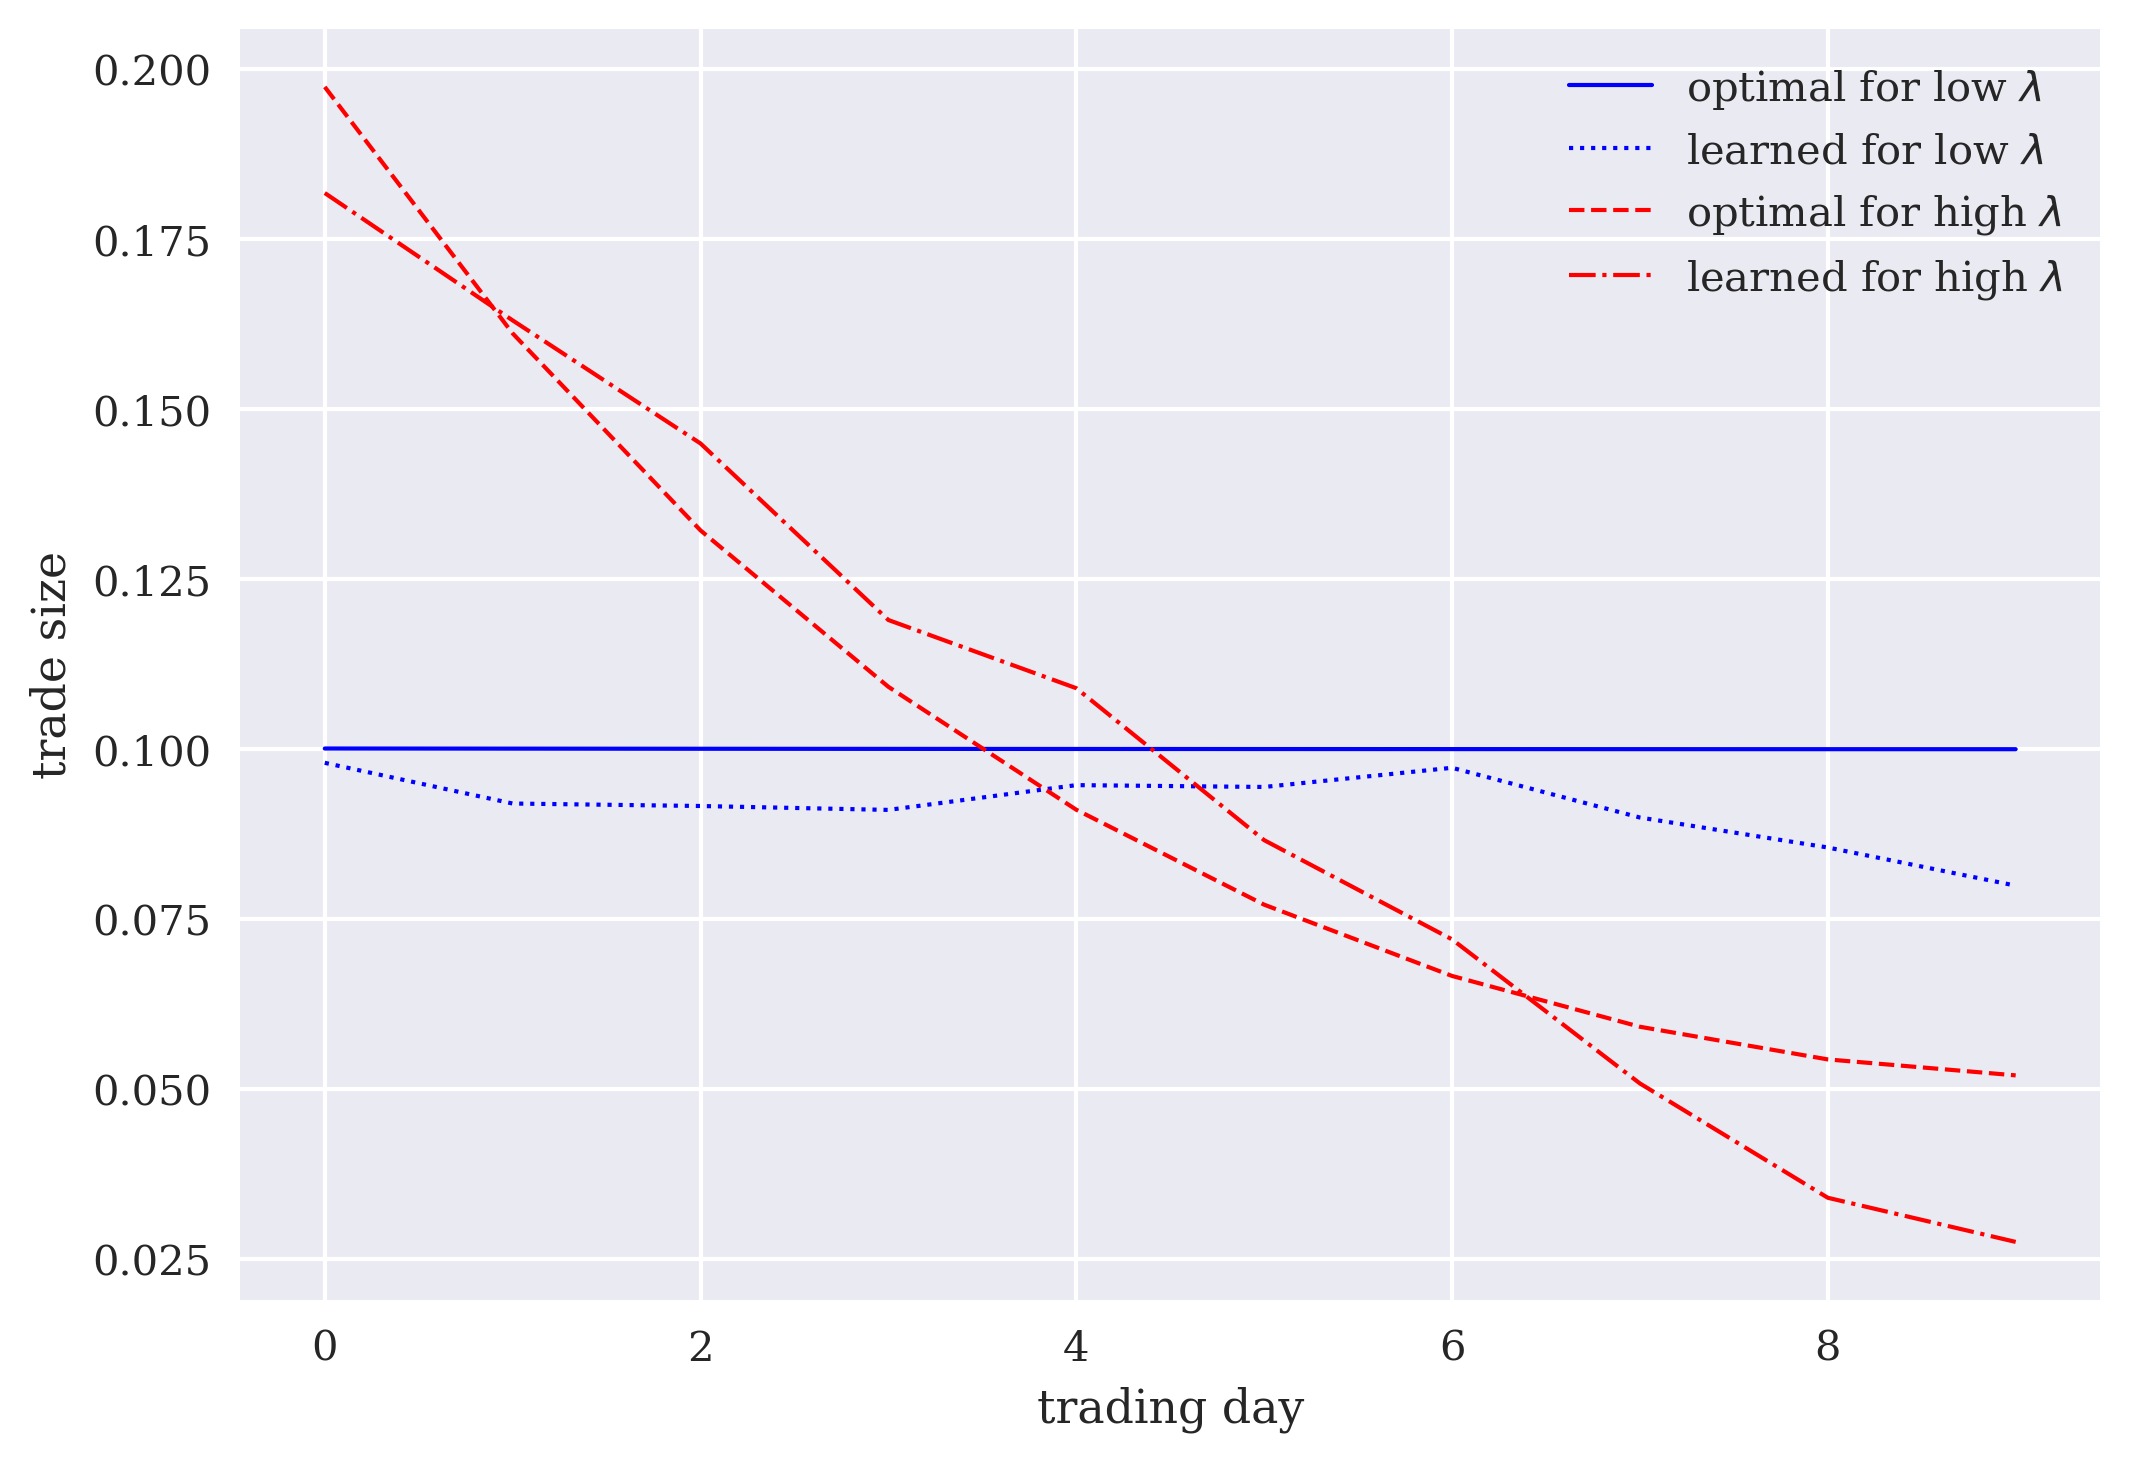

In [72]:
plt.plot(xtl[1:], 'b', lw=1, label='optimal for low $\lambda$')
plt.plot(xtl_[1:], 'b:', lw=1, label='learned for low $\lambda$')
plt.plot(xth[1:], 'r--', lw=1, label='optimal for high $\lambda$')
plt.plot(xth_[1:], 'r-.', lw=1, label='learned for high $\lambda$')
plt.xlabel('trading day')
plt.ylabel('trade size')
plt.legend();

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>